# Praktikum 13 Topic Modeling

<pre>
Nama    : Raihan Rahmanda Junianto
NIM     : 222112303
Kelas   : 3SD2
</pre>

<hr>

## A. Penyiapan Library dan Dataset

In [2]:
### 1. Tahap Persiapan
# Import package/library yang diperlukan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# untuk pre-processing teks
import re, string

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import os
# os.chdir('/Users/xxx/Documents/')
df_train=pd.read_csv('D:/RAIHAN STIS/Perkuliahan/SEMESTER 5/Praktikum INFORMATION RETRIEVAL/Pertemuan (10)/train0.csv')
print(df_train.shape)
df_train.head()

(3638, 2)


,sentence,sentiment
0,Kangen NaBil @RealSyahnazS @bangbily RaGa @Raf...,1
1,Doa utk orang yg mberi makan: Ya Allah! Berila...,1
2,"Setiap kali HP aku bunyi, aku selalu berharap ...",1
3,Belum pernah sedekat ini wawancara dgn Afgan S...,1
4,Dulu masa first pergi award show amatlah malas...,1


In [4]:
df_test=pd.read_csv('D:/RAIHAN STIS/Perkuliahan/SEMESTER 5/Praktikum INFORMATION RETRIEVAL/Pertemuan (10)/test0.csv')
print(df_test.shape)
df_test.head()

(1011, 2)


,sentence,sentiment
0,#Sports Perempuan Golkar Makassar Dibekali Ilm...,1
1,"Se-jauh""nya, Se-kenal""nya, Se-pisah""nya, Se-cu...",1
2,Sekedar Shared Ucapan Terimakasih Charles Hono...,1
3,Wah pak Jokowi sudah mendapat nilai positif di...,1
4,Penelpon : raffi ahmad oh raffi ahmad..... *bu...,1


In [5]:
# untuk pre-processing teks
#1. Common text preprocessing
text = "@user Teks ini mau dibersihkan. Ada beberapa karakter seperti: <br>, ?, :, '' spasi berlebih dan tab . "
# mengubah ke huruf kecil (lowercase) dan menghapus tanda baca, karakter aneh dan strip
def preprocess(text):
    text = text.lower() #lowercase text
    text = text.strip() #Menghapus leading/trailing whitespace
    text = re.sub('@[^\s]+','atUser',text) #mengubah @user menjadi atUser
    text = re.sub(r'#([^\s]+)', r'\1', text) #menghapus hashtag di depan suatu kata
    text= re.compile('<.*?>').sub('', text) #Menghapus HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)

    #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text) #Menghapus extra space dan tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace
    return text

preprocess(text)

'atUser teks ini mau dibersihkan ada beberapa karakter seperti spasi berlebih dan tab'

In [6]:
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens
#STOPWORD ELIMINATION DAN STEMMING
def stemming(text, stemmer):
    # stemming process
    output = stemmer.stem(text)
    return output
def stemming_stopword_elim(text, stopwords, stemmer):
    output = ""
    for token in tokenisasi(text):
        if not token in stopwords:
            output = output + stemming(token, stemmer) + " "
    return output[:-1]

In [7]:
#FINAL PREPROCESSING
from spacy.lang.id import Indonesian
import spacy
nlp = Indonesian() # use directly
nlp = spacy.blank('id') # blank instance'
stopwords = nlp.Defaults.stop_words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [8]:
def finalpreprocess(string):
    return preprocess(string)

In [9]:
df_train['clean_text'] = df_train['sentence'].apply(lambda x:finalpreprocess(x))
df_train.head()

,sentence,sentiment,clean_text
0,Kangen NaBil @RealSyahnazS @bangbily RaGa @Raf...,1,kangen nabil atUser atUser raga atUser atUser ...
1,Doa utk orang yg mberi makan: Ya Allah! Berila...,1,doa utk orang yg mberi makan ya allah berilah ...
2,"Setiap kali HP aku bunyi, aku selalu berharap ...",1,setiap kali hp aku bunyi aku selalu berharap i...
3,Belum pernah sedekat ini wawancara dgn Afgan S...,1,belum pernah sedekat ini wawancara dgn afgan s...
4,Dulu masa first pergi award show amatlah malas...,1,dulu masa first pergi award show amatlah malas...


In [10]:
df_test['clean_text'] = df_test['sentence'].apply(lambda x:finalpreprocess(x))
df_test.head()

,sentence,sentiment,clean_text
0,#Sports Perempuan Golkar Makassar Dibekali Ilm...,1,sports perempuan golkar makassar dibekali ilmu...
1,"Se-jauh""nya, Se-kenal""nya, Se-pisah""nya, Se-cu...",1,se jauh nya se kenal nya se pisah nya se cuek ...
2,Sekedar Shared Ucapan Terimakasih Charles Hono...,1,sekedar shared ucapan terimakasih charles hono...
3,Wah pak Jokowi sudah mendapat nilai positif di...,1,wah pak jokowi sudah mendapat nilai positif di...
4,Penelpon : raffi ahmad oh raffi ahmad..... *bu...,1,penelpon raffi ahmad oh raffi ahmad bukannya s...


## B. Visualisasi Menggunakkan Wordcloud

In [11]:
text_negatif = pd.concat([df_train[df_train['sentiment']==0]['clean_text'], df_test[df_test['sentiment']==0]['clean_text']])
print(text_negatif)

1071    wifi tidak bisa dipakai banyak noda di sprei b...
1072    kangen karimata pengen makan kepiting rebus di...
1073    kamar oke fasilitas oke kasur keras mungkin bi...
1074    tidak ada pelayanan saat datang dan bantuan ba...
1075    inikah namanya cinta sendirian yang kurasakan ...
                              ...                        
1006    cinta itu emang aneh contohnya sekarang aku la...
1007    lokasi beda dengan spot hotelnya muter nyari s...
1008                   terlalu berdebu dan kurang menarik
1009    kurang baik pelayanannya masa tamu hrs diketaw...
1010    untuk room dan fasilitas nya ok untuk staff ny...
Name: clean_text, Length: 3280, dtype: object


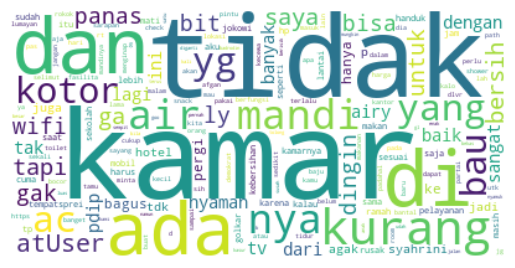

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
text = " ".join(text_negatif.tolist())
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## C. Topic Modeling dengan LSA

In [13]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
text_negatif_vectors = tfidf_vectorizer.fit_transform(text_negatif)
print(text_negatif_vectors.shape)

(3280, 8109)


In [14]:
from sklearn.decomposition import TruncatedSVD
# SVD represent documents and terms in vectors
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(text_negatif_vectors)
len(svd_model.components_)

5

In [15]:
terms = tfidf_vectorizer.get_feature_names_out()
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
    print("")

Topic 0: 
kamar
tidak
kurang
dan
ada
mandi
ac
nya
air
bersih

Topic 1: 
kurang
dingin
ac
bersih
nya
pelayanan
ramah
baik
bagus
cuma

Topic 2: 
http
atuser
ac
dingin
ly
bit
pdip
jokowi
nya
syahrini

Topic 3: 
ac
tidak
dingin
panas
air
nya
ada
berfungsi
gak
ga

Topic 4: 
ac
kotor
kamar
dingin
bau
nya
mandi
agak
ga
http



## D. Topic Modeling dengan LDA

In [16]:
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens

tokens_negatif = [tokenisasi(t) for t in text_negatif]
print(tokens_negatif)

[['wifi', 'tidak', 'bisa', 'dipakai', 'banyak', 'noda', 'di', 'sprei', 'banyak', 'nyamuk'], ['kangen', 'karimata', 'pengen', 'makan', 'kepiting', 'rebus', 'dicocol', 'sambel', 'lagiii', 'huhu'], ['kamar', 'oke', 'fasilitas', 'oke', 'kasur', 'keras', 'mungkin', 'bisa', 'lebih', 'diperhatikan', 'kebersihannya'], ['tidak', 'ada', 'pelayanan', 'saat', 'datang', 'dan', 'bantuan', 'bawa', 'barang', 'pada', 'hal', 'kami', 'kesulitan', 'saat', 'masuk', 'kamar', 'bau', 'apek', 'sekali', 'hingga', 'dua', 'jam', 'hingga', 'kami', 'bantu', 'pewangian'], ['inikah', 'namanya', 'cinta', 'sendirian', 'yang', 'kurasakan', 'tiada', 'cinta', 'sendirian', 'by', 'syahrini', 'maruli', 'w', 'adinda', 'https', 'path', 'com', 'p', 'pypue'], ['check', 'in', 'yang', 'lama', 'ruangan', 'kamar', 'kurang', 'bersih', 'da', 'toilet', 'tidak', 'terwat', 'shower', 'tidak', 'bisa', 'digunakan'], ['pelayannya', 'kurang', 'sopan', 'tertawa', 'terbahak', 'bahak', 'dan', 'menatap', 'remeh', 'tamu'], ['medialampung', 'pasti'

In [17]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(tokens_negatif)
# Create Corpus
# Term Frequency
corpus = [id2word.doc2bow(text) for text in tokens_negatif]
# View
print(id2word)
print(corpus[:1])

Dictionary<8136 unique tokens: ['banyak', 'bisa', 'di', 'dipakai', 'noda']...>
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('banyak', 2),
  ('bisa', 1),
  ('di', 1),
  ('dipakai', 1),
  ('noda', 1),
  ('nyamuk', 1),
  ('sprei', 1),
  ('tidak', 1),
  ('wifi', 1)]]

In [19]:
# Build LDA model
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=10, random_state=100, chunksize=100, passes=10, per_word_topics=True)

In [20]:
lda_model.print_topics() #num_word default is 10

[(0,
  '0.018*"di" + 0.015*"tapi" + 0.010*"tidak" + 0.010*"air" + 0.009*"hp" + 0.007*"wifi" + 0.007*"bertahan" + 0.007*"sama" + 0.006*"bisa" + 0.006*"buruk"'),
 (1,
  '0.012*"di" + 0.009*"sekolah" + 0.009*"yang" + 0.007*"dan" + 0.007*"kantor" + 0.007*"lebih" + 0.006*"mobil" + 0.005*"penumpang" + 0.005*"rumah" + 0.005*"kebersihan"'),
 (2,
  '0.067*"http" + 0.024*"pdip" + 0.023*"atUser" + 0.022*"ly" + 0.021*"bit" + 0.018*"jokowi" + 0.013*"com" + 0.012*"golkar" + 0.012*"demokrat" + 0.010*"tak"'),
 (3,
  '0.032*"p" + 0.032*"com" + 0.032*"https" + 0.030*"path" + 0.020*"afgan" + 0.020*"by" + 0.013*"kau" + 0.012*"aku" + 0.012*"yang" + 0.010*"cinta"'),
 (4,
  '0.018*"saya" + 0.014*"check" + 0.012*"in" + 0.011*"ga" + 0.011*"ada" + 0.009*"di" + 0.009*"jam" + 0.008*"lagi" + 0.008*"yg" + 0.008*"bisa"'),
 (5,
  '0.024*"pergi" + 0.018*"dia" + 0.011*"dan" + 0.011*"yang" + 0.009*"di" + 0.009*"ke" + 0.009*"no" + 0.009*"jangan" + 0.009*"lagi" + 0.008*"kita"'),
 (6,
  '0.032*"atUser" + 0.010*"gak" + 0.00

In [21]:
print("Topic distribution for document:", " ".join(tokens_negatif[0]))
print("feature of each token:", [(id2word[id], freq) for id, freq in corpus[0]])
lda_model.get_document_topics(corpus[0])

Topic distribution for document: wifi tidak bisa dipakai banyak noda di sprei banyak nyamuk
feature of each token: [('banyak', 2), ('bisa', 1), ('di', 1), ('dipakai', 1), ('noda', 1), ('nyamuk', 1), ('sprei', 1), ('tidak', 1), ('wifi', 1)]


[(8, 0.9181685)]

In [22]:
def format_topics_sentences(ldamodel, corpus, texts):
 # Init output
 sent_topics_df = pd.DataFrame()
 
 # Get main topic in each document
 for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
 
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0: # => dominant topic
        wp = ldamodel.show_topic(topic_num, 5) #get most significant topic
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tokens_negatif)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Topic Keywords', 'Text']

#Save to csv
df_dominant_topic.to_csv('D:/RAIHAN STIS/Perkuliahan/SEMESTER 5/Praktikum INFORMATION RETRIEVAL/Pertemuan (13)/doc_topic_dominant.csv')

# Show
df_dominant_topic.head(5)

IndexError: list index out of range

In [23]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens_negatif, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4578162437330853


In [24]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
print('\nCoherence Per Topic Score: ', coherence_per_topic)


Coherence Per Topic Score:  [0.45768478616558667, 0.4105897342749033, 0.4541851553872448, 0.5408178562893514, 0.5867824334293019, 0.4236705877218161, 0.20982564081047483, 0.38543452915651627, 0.5894911258280617, 0.5196805882675963]


In [25]:
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=100,
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts,
        dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

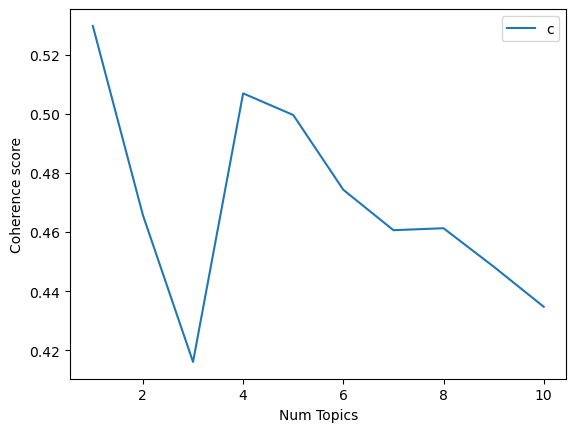

In [26]:
start=1
limit=11
step=1
model_list, coherence_values = compute_coherence_values(id2word, corpus, tokens_negatif, start=start, limit=limit, step=step)
#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.278467  0.117473       1        1  46.420714
2      0.223503  0.233484       2        1  13.139225
4     -0.146109  0.011758       3        1   7.938990
9      0.092289 -0.065466       4        1   5.778523
6      0.017399  0.013973       5        1   5.394887
0     -0.105156 -0.016985       6        1   5.072716
5      0.014315 -0.110034       7        1   4.829183
3      0.072395 -0.121532       8        1   4.546712
1      0.038653 -0.033596       9        1   3.651589
7      0.071177 -0.029075      10        1   3.227460, topic_info=        Term         Freq        Total Category  logprob  loglift
92      http   576.000000   576.000000  Default  30.0000  30.0000
21     kamar  1269.000000  1269.000000  Default  29.0000  29.0000
552   atUser   288.000000   288.000000  Default  28.0000  28.0000
7      tidak  1073.000000  1073.000000  Default  27.0000  27.0000
52       com   189.000000   189.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
200  sekolah     7.127339    88.368224  Topic10  -5.5589   0.9159
347    orang     6.955013    74.527210  Topic10  -5.5834   1.0618
184      goo     6.741839    49.769954  Topic10  -5.6145   1.4344
477       hp     7.009569    92.109215  Topic10  -5.5756   0.8578
35       dan     7.699167   932.450055  Topic10  -5.4817  -1.3632

[642 rows x 6 columns], token_table=      Topic      Freq Term
term                      
519       1  0.288140     
519       2  0.309887     
519       3  0.005437     
519       4  0.092422     
519       5  0.081549     
...     ...       ...  ...
260       6  0.016993   yg
260       7  0.031153   yg
260       8  0.025489   yg
260       9  0.002832   yg
260      10  0.002832   yg

[1203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 5, 10, 7, 1, 6, 4, 2, 8])